In [1]:
# import the necessary libraries
import torch
import nltk
import datasets
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# load dataset 
wikipedia_text = datasets.load_dataset("wikitext", "wikitext-2-raw-v1", split='train')["text"]


In [4]:
import string
def create_vocab(dataset):
    #nltk.download('punkt')
    # create one big string 
    dataset = "".join(dataset)
    # remove punctuation, whitespaces and convert to lowcase
    dataset = dataset.translate(str.maketrans('', '', string.punctuation)).strip().lower()
    # tokenize to words 
    vocab = nltk.word_tokenize("".join(dataset))
    # remove repeated words
    vocab = set(vocab)
    print(f"Vocab size: {len(vocab)}")
    return list(vocab)

vocab = create_vocab(wikipedia_text)

Vocab size: 66168


In [5]:
from collections import defaultdict

# create a mapping between words to integers (for indexing)
wtoi = {word: i for i, word in enumerate(["<UNK>"] + vocab)}
wtoi = defaultdict(int, wtoi)

# ... integers to words
itow = {i: word for i, word in enumerate(wtoi)}
itow = defaultdict(lambda: "<UNK>", itow)

In [6]:
class SkipGram(nn.Module):
    """Creates two embedding matrices. 

    Implements skip-gram model of word2vec. 

    Args:
        vocab_size (int): Amount of different words in vocabulary, corresponds amount of embedding vectors
        embed_dim (int): Dimension of embedding vectors.
    """
    def __init__(self, vocab_size, embed_dim=128):
        
        super().__init__()
        self.center_embeds = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.context_embeds = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)


    def forward(self, x):
        center_word = self.center_embeds(x)

        scores = torch.matmul(center_word, self.context_embeds.weight.t())

        return scores

    def get_N_closest(self, x, N=5):
        """
        Turns x intro embedding, then through cosine similarity selects N most similar center vector embeddings.
        Args:
            x (torch.tensor): tensor with a single integer represeting X's index in vocabulary
            N (int): Amount of closest word indices to X.
        
        Returns:
            List of tensor indices of the closest words to X

        Example:
        center_idx = torch.tensor([wtoi["valkyria"]]).to(device)
        indices = w2v.get_N_closest(center_idx))
        print(itow[idx.item()] for idx in indices)
        """
        
        # get word vector
        x = self.center_embeds(x)
        # calculate cosine similarity between x and center vector
        cos_sim = nn.CosineSimilarity(dim=-1)
        similarities = cos_sim(x, self.center_embeds.weight)
        #similarities = cos_sim(x, self.context_embeds.weight)
        _, indices = torch.topk(similarities, N)
        return indices


In [7]:
corpus_words = ("".join(wikipedia_text)).translate(str.maketrans('', '', string.punctuation)).lower().strip()

In [8]:
from torch.utils.data import DataLoader

class SkipGramDataset():
    """Creates dataset for skipgram model.

    For input ["cat", "on", "the", "mat"] will create dataset (cat, on), (on, cat), (on, the), (the, on), (the, mat), (mat, the) if window is set to 1.
    Important note, created datasets won't contain words but integers correspoding to their indices in the vocabulary.
    
    Args:
        data (list): List of strings used to create the dataset.
        window (int): Lenght of context.
    """
    def __init__(self, data, window=2):
        super().__init__()
        self.dataset = []
        self.window = window
        self.X, self.Y = self.create_dataset(data)
        self.X, self.Y = self.X.to(device), self.Y.to(device) 

    def create_dataset(self, data):
        stopwords = nltk.corpus.stopwords.words('english') + ["=", ":", ",", "(", ")", "{", "}", "[", "]"]
        window = self.window
        xs, ys = [], []
        for i in range(0, len(data)):
            if data[i] in stopwords:
                continue
            center_word = wtoi[data[i]]
            for j in range(i-window, i+window+1):
                if j == i or j<0 or j>len(data)-1 or data[j] in stopwords:
                    continue
                context_word = wtoi[data[j]]

                xs.append(center_word)
                ys.append(context_word)
        return torch.tensor(xs), torch.tensor(ys)

    def __getitem__(self, val):
        if type(val) is slice:
            return list(zip(self.X[val], self.Y[val]))
        return (self.X[val], self.Y[val])

    def __len__(self):
        lenX = len(self.X)
        assert lenX == len(self.Y)
        return lenX


dataset = SkipGramDataset(window=2, data=corpus_words.split())
dl = DataLoader(dataset, batch_size=4096, shuffle=True)

In [9]:
w2v = SkipGram(len(wtoi)).to(device)
optimizer = torch.optim.Adam(w2v.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm
EPOCHS=100
total_losses = []

for epoch in tqdm(range(EPOCHS)):
    epoch_loss = []
    for center, context in dl:
        x = w2v(center)

        loss = loss_fn(x, context)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    total_losses.append(epoch_loss.item())

In [24]:
def predictions_to_words(xz):
    for i in xz:
        idx = i.item()
        print(itow[idx])

center_idx = torch.tensor([wtoi["japan"]]).to(device)
predictions_to_words(w2v.get_N_closest(center_idx))

japan
2011
australia
2009
17


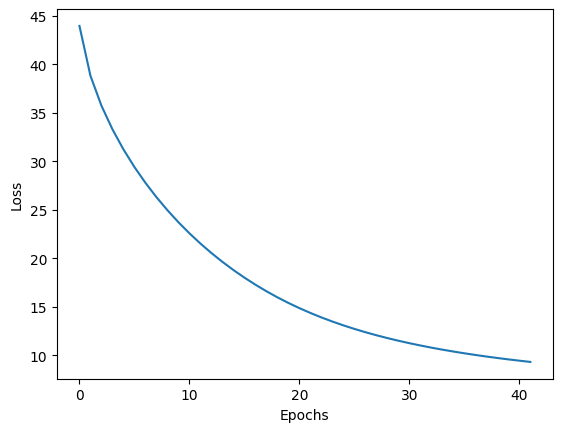

In [28]:
import matplotlib.pyplot as plt

plt.plot(range(len(total_losses)), total_losses)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()